In [1]:
import sys
sys.path.append('..')

import utils, selex_dca, indep_sites
import adabmDCA
import selex_distribution, energy_models, tree, data_loading, training, callback

import torch
from utils import one_hot
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

/Users/scrotti/Aptamer2025py/selex_dca.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [7]:
experiment_id = "Dop8V030"
round_ids = ["ARN", "R01", "R01CS", "R02N"]

device = torch.device("cpu")
dtype = torch.float64

In [ ]:
sequences = []
for round_id in round_ids:
    s = utils.sequences_from_file(experiment_id, round_id, device)
    sequences.append(s)
    print(f"finished {round_id}")

In [9]:
sequences_oh = [one_hot(seq).to(dtype=dtype, device=device) for seq in sequences]

In [ ]:
# del sequences

In [11]:
total_reads = torch.Tensor([s.shape[0] for s in sequences_oh]).to(device)
fi0, _, _ = utils.frequences_from_sequences_oh(sequences_oh[0])

In [12]:
tr = tree.Tree()
tr.add_node(-1, name = "R01")
tr.add_node(-1, name = "R01CS")
tr.add_node(0, name = "R02N")

mode_names = ["target", "bead"]

selected_modes = torch.BoolTensor(
    [[1, 1],[1, 1], [0, 1]]
).to(device)

In [14]:
L, q = sequences_oh[0][0].shape

k = torch.zeros(L, q, dtype=dtype, device=device)
# k = torch.log(fi0)
h_target = torch.zeros(L, q, dtype=dtype, device=device)
J_target = torch.zeros(L, q, L, q, dtype=dtype, device=device)
h_bead = torch.zeros(L, q, dtype=dtype, device=device)
J_bead = torch.zeros(L, q, L, q, dtype=dtype, device=device)

Ns0 = energy_models.IndepSites(k)
potts_target = energy_models.Potts(J_target, h_target)
potts_bead = energy_models.Potts(J_bead, h_bead)

ps = selex_distribution.MultiModeDistribution(potts_target, potts_bead, normalized=True)
model = selex_distribution.MultiRoundDistribution(Ns0, ps, tr, selected_modes)

In [15]:
batch_size = 10**6
data_loaders = [data_loading.SelexRoundDataLoader(seq_oh, batch_size=batch_size) for seq_oh in sequences_oh]
n_rounds = len(data_loaders) 

In [16]:
n_chains = 10**3

chains = training.init_chains(n_rounds, n_chains, L, q, device, dtype)
log_weights = torch.zeros(n_rounds, n_chains, device=device, dtype=dtype)

In [17]:
callbacks = [callback.ConvergenceMetricsCallback(), callback.PearsonCovarianceCallback()]

In [18]:
%load_ext line_profiler

In [ ]:
n_sweeps = 10
lr = 0.01
target_pearson = 1
max_epochs = 20

%lprun -f training.train training.train(model, data_loaders, total_reads, chains, n_sweeps, lr, max_epochs, target_pearson, callbacks=callbacks)

 0.00%[                               ] Epoch: 0/20 [00:00, ?it/s]

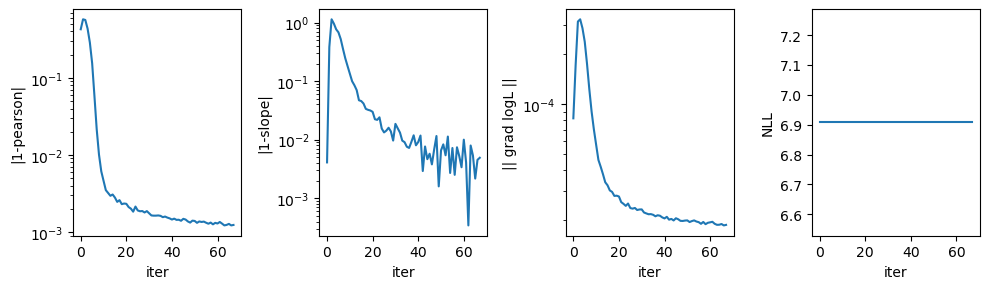

In [34]:
callbacks[0].plot();

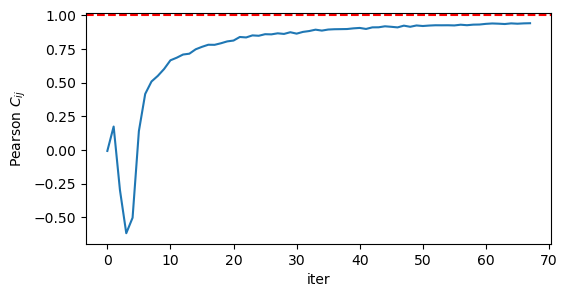

In [35]:
fig, ax = callbacks[1].plot()
ax.axhline(1, color='r', linestyle='--')

<IPython.core.display.Latex object>

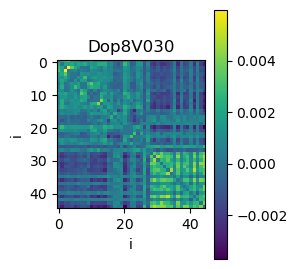

In [36]:
from IPython.display import display, Latex

potts_zerosum = potts_target.set_zerosum_gauge()

pl, ax = plt.subplots(figsize=(3,3))
F = selex_dca.get_contact_map(potts_zerosum.J.detach())
im = ax.imshow(F)
ax.set_xlabel("i"); ax.set_ylabel("i")
ax.set_title(experiment_id)
plt.colorbar(im)
plt.tight_layout()
# im.set_clim(-0.0015, 0.0030)
display(Latex("$F_{ij}=\\sqrt {\\sum_{ab}(J_{ij}^{ab})^2}$"))

<IPython.core.display.Latex object>

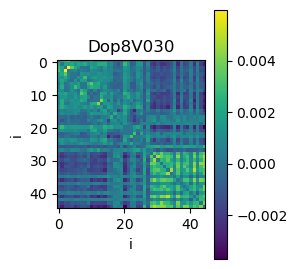

In [37]:
from IPython.display import display, Latex

potts_zerosum = potts_bead.set_zerosum_gauge()

pl, ax = plt.subplots(figsize=(3,3))
F = selex_dca.get_contact_map(potts_zerosum.J.detach())
im = ax.imshow(F)
ax.set_xlabel("i"); ax.set_ylabel("i")
ax.set_title(experiment_id)
plt.colorbar(im)
plt.tight_layout()
# im.set_clim(-0.0015, 0.0030)
display(Latex("$F_{ij}=\\sqrt {\\sum_{ab}(J_{ij}^{ab})^2}$"))

In [40]:
potts_bead.J

Parameter containing:
tensor([[[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [-3.1730e-04,  4.2900e-03,  2.0173e-03,  1.5838e-02],
          [ 6.0064e-04,  1.1003e-04,  1.8411e-02,  2.7065e-03],
          ...,
          [-1.2014e-03,  1.0405e-03, -7.3873e-04,  2.2728e-02],
          [-2.4736e-04,  1.8288e-02,  2.9333e-04,  3.4937e-03],
          [ 2.0490e-03,  5.2704e-04,  1.6698e-02,  2.5535e-03]],

         [[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [-1.9994e-03, -2.5409e-03, -2.0409e-03, -7.0415e-04],
          [-2.5084e-03, -2.3487e-03, -3.3772e-04, -2.0905e-03],
          ...,
          [-2.5369e-03, -2.4899e-03, -2.5454e-03,  2.8681e-04],
          [-2.4946e-03,  2.6959e-05, -2.4906e-03, -2.3272e-03],
          [-2.3762e-03, -2.2351e-03, -3.5792e-04, -2.3162e-03]],

         [[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [-1.3602e-03, -2.6039e-03, -2.3440e-03,  3.6348e-03],
          [-2.1667e-03, -1.2024e-03,  2.7752e-03

In [41]:
potts_target.J

Parameter containing:
tensor([[[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 3.1730e-04, -4.2900e-03, -2.0173e-03, -1.5838e-02],
          [-6.0064e-04, -1.1003e-04, -1.8411e-02, -2.7065e-03],
          ...,
          [ 1.2014e-03, -1.0405e-03,  7.3873e-04, -2.2728e-02],
          [ 2.4736e-04, -1.8288e-02, -2.9333e-04, -3.4937e-03],
          [-2.0490e-03, -5.2704e-04, -1.6698e-02, -2.5535e-03]],

         [[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 1.9994e-03,  2.5409e-03,  2.0409e-03,  7.0415e-04],
          [ 2.5084e-03,  2.3487e-03,  3.3772e-04,  2.0905e-03],
          ...,
          [ 2.5369e-03,  2.4899e-03,  2.5454e-03, -2.8681e-04],
          [ 2.4946e-03, -2.6959e-05,  2.4906e-03,  2.3272e-03],
          [ 2.3762e-03,  2.2351e-03,  3.5792e-04,  2.3162e-03]],

         [[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 1.3602e-03,  2.6039e-03,  2.3440e-03, -3.6348e-03],
          [ 2.1667e-03,  1.2024e-03, -2.7752e-03